In [1]:
import sys
from itertools import chain, product
from typing import List, Tuple, Optional, Any, Dict
import pandas as pd

from rdkit import Chem
from rdkit.Chem import PandasTools

sys.path.append('..')
import torch.nn as nn
from torch_geometric.loader import DataLoader

from src.models.egnn import EquivariantGNN
from src.models.negnn import NaiveEuclideanGNN
from src.preprocessing.chem import molecule_to_Data
from src.tools import *

from rhea.chem.molecule import Molecule, to2d
from rhea.chem.moleculefilters import FragmentLikeness, RuleOfThree

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [2]:
fraglike = FragmentLikeness()
ro3 = RuleOfThree()

# Data preparation

In [3]:
# # testing
# fig = plt.figure(figsize=(8, 8))

# for ax_pos in [221, 222, 223, 224]:
#     pos = np.random.rand(3, 5)
#     color = np.random.rand(5)
#     plot_point_cloud_3d(fig, ax_pos, color, pos)

# fig.suptitle("Random test point clouds")
# fig.tight_layout()

In [4]:
# df = PandasTools.LoadSDF('../data/QM9/raw/gdb9.sdf')
# df.shape

In [5]:
# props = pd.read_csv('../data/QM9/raw/gdb9.sdf.csv')
# props.shape

In [6]:
# print(props.columns)
# print(df.columns)

In [7]:
# # join the two dataframes df on ID and props on mol_id
# df = df.join(props.set_index('mol_id'), on='ID')
# df.shape

In [8]:
# %%timeit

# df["FragmentLikeness"] = df.ROMol.apply(fraglike.filter)
# df["Ro3"] = df.ROMol.apply(ro3.filter)

In [9]:
# df = df[df.FragmentLikeness & df.Ro3]
# df.shape

In [10]:
# # store df using pkl
# df.to_pickle('../data/QM9/raw/gdb9.pkl')

# To Data object

In [11]:
# # load df using pkl
df = pd.read_pickle('../data/QM9/raw/gdb9.pkl')

In [12]:
# from tqdm import tqdm

# for idx, i in enumerate(tqdm(range(len(test)))):
#     m = test.ROMol.iloc[i]
#     m = Chem.AddHs(m, addCoords=True)
#     m = Molecule(m)
#     m = molecule_to_Data(m, idx)
    
# m = df.ROMol.iloc[0]
# m = Chem.AddHs(m, addCoords=True)
# m = Molecule(m)
# d = molecule_to_Data(m, 0)

# THIS WORKED AS EXPECTED! 

In [13]:
from tqdm import tqdm
dataset = []
# Create a Dataset
for idx, i in enumerate(tqdm(range(10))):#len(df)
    m = df.ROMol.iloc[i]
    m = Chem.AddHs(m, addCoords=True)
    m = Molecule(m)
    d = molecule_to_Data(m, idx)
    dataset.append(d)

100%|██████████| 10/10 [00:00<00:00, 476.89it/s]


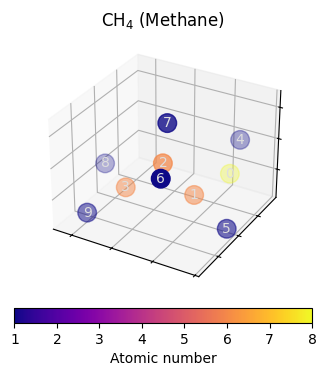

In [14]:
fig = plt.figure()
ax = plot_model_input(dataset[5], fig, 111)
_ = ax.set_title("CH$_4$ (Methane)")

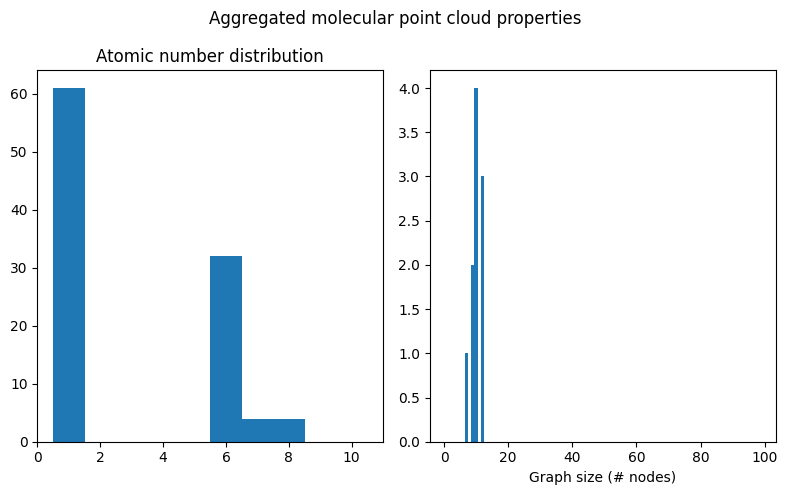

In [15]:
fig, (ax_atoms, ax_graph_size) = plt.subplots(1, 2, figsize=(8, 5))

# historgam of z values (atomic numbers) for all the molecules
ax_atoms.hist(list(chain(*[d.z for d in dataset])), bins=range(1, 12), align='left')
ax_atoms.set_label("Atomic number")
ax_atoms.set_title("Atomic number distribution")
num_nodes = [d.num_nodes for d in dataset]
ax_graph_size.hist(num_nodes, bins=range(1, 100), align='left')
ax_graph_size.set_xlabel("Graph size (# nodes)")
fig.suptitle("Aggregated molecular point cloud properties")
fig.tight_layout()

In [16]:
def shuffle_splits(dataset:List[Data], 
                   train_ratio:float,
                   val_ratio:float,
                   test_ratio:float,
                   seed:int=42) -> Tuple[List[Data], List[Data], List[Data]]:
    """
    Shuffle and split a dataset into training, validation and test sets.
    
    Args:
    - dataset: List of Data objects
    - train_ratio: float, ratio of training set
    - val_ratio: float, ratio of validation set
    - test_ratio: float, ratio of test set
    - seed: int, random seed
    
    Returns:
    - train_loader: DataLoader for training set
    - val_loader: DataLoader for validation set
    - test_loader: DataLoader for test set
    """
    assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1.0"    
    
    np.random.seed(seed)
    N = len(dataset)
    indices = np.random.permutation(N)
    
    train_end = int(train_ratio * N)
    val_end = int((train_ratio + val_ratio) * N)
    
    train_loader = DataLoader([dataset[i] for i in indices[:train_end]], batch_size=32, shuffle=True)
    val_loader = DataLoader([dataset[i] for i in indices[train_end:val_end]], batch_size=32)
    test_loader = DataLoader([dataset[i] for i in indices[val_end:]], batch_size=32)
    
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = shuffle_splits(dataset, 0.8, 0.1, 0.1)

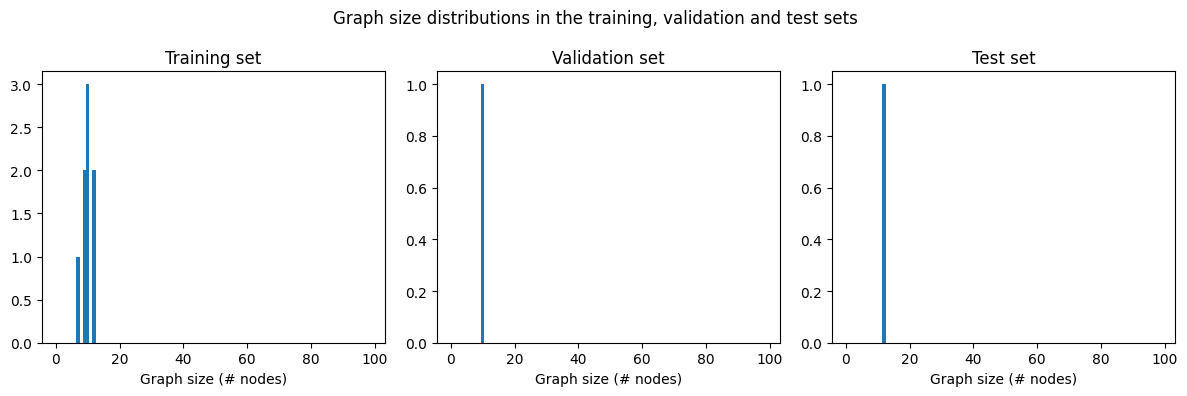

In [17]:
# see plot https://projects.volkamerlab.org/teachopencadd/talktorials/T036_e3_equivariant_gnn.html
# plot distribution of graph sizes in the training, validation and test sets
fig, (ax_train, ax_val, ax_test) = plt.subplots(1, 3, figsize=(12, 4))

train_sizes = [d.num_nodes for d in train_loader.dataset]
val_sizes = [d.num_nodes for d in val_loader.dataset]
test_sizes = [d.num_nodes for d in test_loader.dataset]

ax_train.hist(train_sizes, bins=range(1, 100), align='left')
ax_train.set_xlabel("Graph size (# nodes)")
ax_train.set_title("Training set")

ax_val.hist(val_sizes, bins=range(1, 100), align='left')
ax_val.set_xlabel("Graph size (# nodes)")
ax_val.set_title("Validation set")

ax_test.hist(test_sizes, bins=range(1, 100), align='left')
ax_test.set_xlabel("Graph size (# nodes)")
ax_test.set_title("Test set")

fig.suptitle("Graph size distributions in the training, validation and test sets")
fig.tight_layout()

In [18]:
import math 

# use rotations along z-axis as demo e(3) transformation
def rotation_matrix_z(theta: float) -> Tensor:
    """Generates a rotation matrix and returns
    a corresponing tensor. The rotation is about the $z$-axis.
    (https://en.wikipedia.org/wiki/Rotation_matrix)

    Parameters
    ----------
    theta : float
        the angle of rotation.

    Returns
    -------
    Tensor
        the rotation matrix as float tensor.
    """
    return torch.tensor(
        [
            [math.cos(theta), -math.sin(theta), 0],
            [math.sin(theta), math.cos(theta), 0],
            [0, 0, 1],
        ]
    )

In [19]:
sample_data = dataset[0].clone()

rotated_data = sample_data.clone()

rotated_data.pos = rotated_data.pos @ rotation_matrix_z(45)

In [20]:
model = NaiveEuclideanGNN(
    hidden_channels=32,
    num_layers=2,
    num_spatial_dims=3,
    final_embedding_size=1,
)


/tmp/ipykernel_1080269/1040294942.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


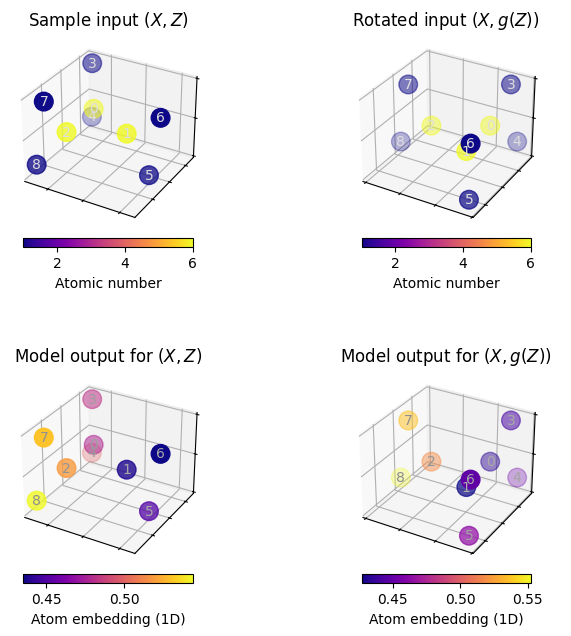

In [21]:
fig = plt.figure(figsize=(8, 8))

ax1 = plot_model_input(sample_data, fig, 221)
ax1.set_title("Sample input $(X, Z)$")

ax2 = plot_model_input(rotated_data, fig, 222)
ax2.set_title("Rotated input $(X, g(Z))$")

ax3 = plot_model_embedding(sample_data, model.encode, fig, 223)
ax3.set_title("Model output for $(X, Z)$")

ax4 = plot_model_embedding(rotated_data, model.encode, fig, 224)
ax4.set_title("Model output for $(X, g(Z))$")
fig.tight_layout()

When executing the above cells a few times, we can observe that rotating the molecule may significantly alter the atom embeddings obtained from the plain GNN model.

/tmp/ipykernel_1080269/2072519676.py:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


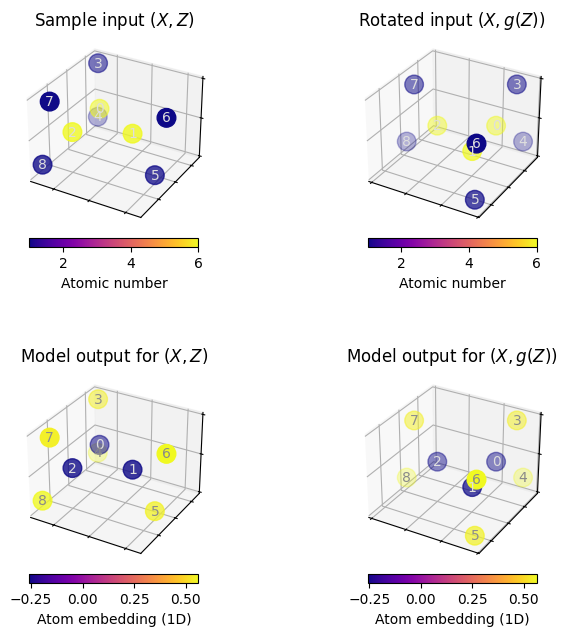

In [22]:
model = EquivariantGNN(hidden_channels=32, final_embedding_size=1, num_mp_layers=2)

sample_data = dataset[0].clone()

rotated_data = sample_data.clone()

rotated_data.pos = rotated_data.pos @ rotation_matrix_z(45)

fig = plt.figure(figsize=(8, 8))

ax1 = plot_model_input(sample_data, fig, 221)
ax1.set_title("Sample input $(X, Z)$")

ax2 = plot_model_input(rotated_data, fig, 222)
ax2.set_title("Rotated input $(X, g(Z))$")

ax3 = plot_model_embedding(sample_data, model.encode, fig, 223)
ax3.set_title("Model output for $(X, Z)$")

ax4 = plot_model_embedding(rotated_data, model.encode, fig, 224)
ax4.set_title("Model output for $(X, g(Z))$")
fig.tight_layout()

You can execute the above cells as often as you like, with whatever input you choose, the atom embeddings will always be unaffected by the rotation applied to the model input.

In [23]:
def total_absolute_error(pred: Tensor, target: Tensor, batch_dim: int = 0) -> Tensor:
    """Total absolute error, i.e. sums over batch dimension.

    Parameters
    ----------
    pred : Tensor
        batch of model predictions
    target : Tensor
        batch of ground truth / target values
    batch_dim : int, optional
        dimension that indexes batch elements, by default 0

    Returns
    -------
    Tensor
        total absolute error
    """
    return (pred - target).abs().sum(batch_dim)

def total_absolute_error(pred: Tensor, target: Tensor) -> Tensor:
    return torch.mean(torch.abs(pred - target))

def run_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: Callable[[Tensor, Tensor], Tensor],
    pbar: Optional[Any] = None,
    optim: Optional[torch.optim.Optimizer] = None,
    device: str = "cuda"
) -> Tuple[float, float]:
    """Run a single epoch.

    Parameters
    ----------
    model : nn.Module
        the NN used for regression
    loader : DataLoader
        an iterable over data batches
    criterion : Callable[[Tensor, Tensor], Tensor]
        a criterion (loss) that is optimized
    pbar : Optional[Any], optional
        a tqdm progress bar, by default None
    optim : Optional[torch.optim.Optimizer], optional
        an optimizer that is optimizing the criterion, by default None
    """

    def step(
        data_batch: Any,
    ) -> Tuple[float, float]:
        """Perform a single train/val step on a data batch.

        Parameters
        ----------
        data_batch : Any

        Returns
        -------
        Tuple[float, float]
            Loss (mean squared error) and validation criterion (absolute error).
        """
        data_batch = data_batch.to(device)
        pred = model(data_batch)
        target = data_batch.y.to(device)
        loss = criterion(pred, target)
        if optim is not None:
            optim.zero_grad()
            loss.backward()
            optim.step()
        return loss.detach().item(), total_absolute_error(pred.detach(), target.detach()).item()

    if optim is not None:
        model.train()
        # This enables pytorch autodiff so we can compute gradients
        model.requires_grad_(True)
    else:
        model.eval()
        # Disable autodiff: when evaluating we do not need to track gradients
        model.requires_grad_(False)

    total_loss = 0
    total_mae = 0
    for data in loader:
        loss, mae = step(data)
        total_loss += loss * data.num_graphs
        total_mae += mae
        if pbar is not None:
            pbar.update(1)

    return total_loss / len(loader.dataset), total_mae / len(loader.dataset)


def train_model(
    train_loader: DataLoader,
    val_loader: DataLoader,
    model: nn.Module,
    num_epochs: int = 30,
    lr: float = 3e-4,
    weight_decay: float = 1e-8,
    device: str = "cuda",
    best_model_path: str = "best_model.pt") -> Dict[str, Any]:
    """Train a model."""
    
    model = model.to(device)
    
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    
    best_val_mae = float("inf")
    
    result = {
        "model": model,
        "train_losses": np.full(num_epochs, np.nan),
        "train_maes": np.full(num_epochs, np.nan),
        "val_losses": np.full(num_epochs, np.nan),
        "val_maes": np.full(num_epochs, np.nan),
        "path": best_model_path,
    }
    
    def update_statistics(i_epoch:int, **kwargs:float) -> None:
        for key, value in kwargs.items():
            result[key][i_epoch] = value
    
    def desc(i_epoch: int) -> str:
        return "|".join(
            [f"Epoch {i_epoch + 1:3d} / {num_epochs}"] +
            [f"{key}: {value[i_epoch]:8.2f}" for key, value in result.items() if isinstance(value, np.ndarray)]
        )

    for i_epoch in range(num_epochs):
        pbar = tqdm(total=len(train_loader)+len(val_loader))
        try:
            pbar.set_description(desc(i_epoch))
            
            train_loss, train_mae = run_epoch(model, train_loader, criterion, pbar, optim, device)
            val_loss, val_mae = run_epoch(model, val_loader, criterion, pbar, None, device)
            
            update_statistics(i_epoch, train_losses=train_loss, train_maes=train_mae, val_losses=val_loss, val_maes=val_mae)
            
            pbar.set_description(desc(i_epoch))
            
            if val_mae < best_val_mae:
                best_val_mae = val_mae
                torch.save(model.state_dict(), best_model_path)
        finally:
            pbar.close()
    
    return result

@torch.no_grad()
def test_model(model: nn.Module, data_loader: DataLoader, device: str = "cuda") -> float:
    """Test a model on a data loader.

    Parameters
    ----------
    model : nn.Module
        the model to be tested
    data_loader : DataLoader
        the data loader to be used
    device : str, optional
        the device to use, by default "cuda"

    Returns
    -------
    float
        the mean absolute error
    """
    model = model.to(device)
    model.eval()
    model.requires_grad_(False)
    
    total_mae = 0
    for data in data_loader:
        data = data.to(device)
        pred = model(data)
        target = data.y.to(device)
        total_mae += total_absolute_error(pred, target).item()
    
    return total_mae / len(data_loader.dataset)


In [25]:
model = EquivariantGNN(hidden_channels=64, num_mp_layers=2).to('cpu')


egnn_train_result = train_model(
    train_loader,
    val_loader,
    model,
    num_epochs=30,
    lr=1e-3,
    weight_decay=1e-8,
    device="cpu",
    best_model_path="best_egnn_model.pt",
)

Epoch   1 / 30|train_losses:      nan|train_maes:      nan|val_losses:      nan|val_maes:      nan:   0%|          | 0/2 [00:00<?, ?it/s]/home/adria/.conda/envs/saturn24/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/adria/.conda/envs/saturn24/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch   1 / 30|train_losses:    21.29|train_maes:     0.54|val_losses:     2.83|val_maes:     1.68: 100%|██████████| 2/2 [00:00<00:00

In [26]:
egnn_train_result

{'model': EquivariantGNN(
   (act): ReLU()
   (f_initial_embed): Embedding(100, 64)
   (message_passing_layers): ModuleList(
     (0-1): 2 x EquivariantMPLayer(
       (act): ReLU()
       (residual_proj): Linear(in_features=64, out_features=64, bias=False)
       (message_mlp): Sequential(
         (0): Linear(in_features=129, out_features=64, bias=True)
         (1): ReLU()
       )
       (node_update_mlp): Sequential(
         (0): Linear(in_features=128, out_features=64, bias=True)
         (1): ReLU()
       )
     )
   )
   (aggregation): SumAggregation()
   (f_predict): Sequential(
     (0): Linear(in_features=64, out_features=64, bias=True)
     (1): ReLU()
     (2): Linear(in_features=64, out_features=1, bias=True)
   )
 ),
 'train_losses': array([2.12872944e+01, 2.67627525e+00, 1.35152531e+00, 9.01414081e-02,
        4.58075583e-01, 5.04513718e-02, 3.53039235e-01, 1.66924492e-01,
        1.39689192e-01, 2.62744576e-01, 3.44284140e-02, 2.01815501e-01,
        1.16895370e-01, 

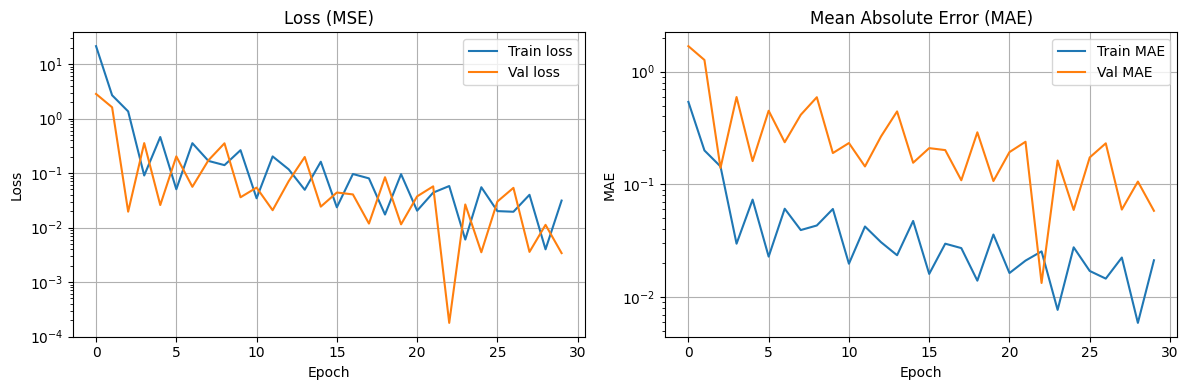

In [30]:
# plot training and validation losses
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(egnn_train_result["train_losses"], label="Train loss")
ax[0].plot(egnn_train_result["val_losses"], label="Val loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss (MSE)")

ax[1].plot(egnn_train_result["train_maes"], label="Train MAE")
ax[1].plot(egnn_train_result["val_maes"], label="Val MAE")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("MAE")
ax[1].set_title("Mean Absolute Error (MAE)")

for a in ax:
    a.legend()
    a.grid()
    a.set_yscale("log")
    
fig.tight_layout()